In [1]:
import pandas as pd
import numpy as np
import os
import email
import email.policy
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from string import punctuation
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re
import heapq

import matplotlib.pyplot as plt

In [2]:
os.listdir('./Database')

['ham', 'spam']

In [3]:
arquivosNormais = [nomeArquivo for nomeArquivo in (os.listdir("./Database/ham")) if len(nomeArquivo) > 20]
arquivosSpam = [nomeArquivo for nomeArquivo in (os.listdir("./Database/spam")) if len(nomeArquivo) > 20]

In [4]:
secondaryDatabaseOnlySpam = pd.read_csv('onlySpam.csv',delimiter=',').drop(columns=["Unnamed: 0"])

arquivosSpamSecondary = [f"spam{i+len(arquivosSpam)}" for i in range(len(secondaryDatabaseOnlySpam))]

In [5]:
def carregarEmail(tipo, arquivo):
    caminho = ""

    if tipo == "spam":
        caminho = "./Database/spam"
    if tipo == "ham":
        caminho = "./Database/ham"

    with open(f"{caminho}/{arquivo}", "rb") as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)


emailsNormais = [carregarEmail("ham", arquivo) for arquivo in arquivosNormais]
emailsSpam = [carregarEmail("spam", arquivo) for arquivo in arquivosSpam]

In [6]:
for i in range(len(arquivosNormais)):
    arquivosNormais[i] = f"ham{i}"

for i in range(len(arquivosSpam)):
    arquivosSpam[i] = f"spam{i}"

emailsNome = arquivosNormais + arquivosSpam

emailsNome += arquivosSpamSecondary

In [7]:
emails = emailsNormais + emailsSpam

aux = emailsNormais[0]

In [8]:
for i in aux.keys():
    print(f"{i} : {aux[i]}")

print('\n')
print('Conteudo:', aux.get_content())

Return-Path : <exmh-workers-admin@example.com>
Delivered-To : zzzz@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Delivered-To : zzzz@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 

In [9]:
def get_email_structure(email):
    if isinstance(email, str):
        return email

    payload = email.get_payload()

    if isinstance(payload, list):
        lista = []
        for sub_email in payload:
            lista.append(get_email_structure(sub_email))

        return "Estruturas do email:", lista

    else:

        return email.get_content_type()


emailsNormaisMultipart = get_email_structure(emailsNormais[634])

In [10]:
emailsNormaisMultipart

('Estruturas do email:', ['text/plain', 'text/html'])

In [11]:

for email in emailsNormais[634].walk():
    print(email)

Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.example.com
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id C2C2316F16
	for <jm@localhost>; Fri, 13 Sep 2002 13:37:26 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Fri, 13 Sep 2002 13:37:26 +0100 (IST)
Received: from xent.com ([64.161.22.236]) by dogma.slashnull.org
    (8.11.6/8.11.6) with ESMTP id g8CNsQC20509 for <jm@jmason.org>;
    Fri, 13 Sep 2002 00:54:27 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id A31B02940D3; Thu, 12 Sep 2002 16:51:04 -0700 (PDT)
Delivered-To: fork@example.com
Received: from web13003.mail.yahoo.com (web13003.mail.yahoo.com
    [216.136.174.13]) by xent.com (Postfix) with SMTP id 5696629409A for
    <fork@xent.com>; Thu, 12 Sep 2002 16:50:13 -0700 (PDT)
Message-Id: <20020912235313.4003.qmail@web13003.mail.yahoo.com>
Received: from

In [12]:
def html_to_text(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n', '')
    except:
        return "empty"


def email_to_text(email):
    for emailParts in email.walk():
        if emailParts.get_content_type() not in ['text/plain', 'text/html']:
            continue

        try:
            emailPartsContent = emailParts.get_content()
        except:
            emailPartsContent = str(emailParts.get_payload())

        if emailParts.get_content_type() == 'text/plain':
            return emailPartsContent
        else:
            return html_to_text(emailParts)


'''def email_to_text(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: # in case of encoding issues
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_text(part)'''


"def email_to_text(email):\n    struct = get_email_structure(email)\n    for part in email.walk():\n        partContentType = part.get_content_type()\n        if partContentType not in ['text/plain','text/html']:\n            continue\n        try:\n            partContent = part.get_content()\n        except: # in case of encoding issues\n            partContent = str(part.get_payload())\n        if partContentType == 'text/plain':\n            return partContent\n        else:\n            return html_to_text(part)"

In [13]:
email_to_text(emailsNormais[0])

'    Date:        Wed, 21 Aug 2002 10:54:46 -0500\n    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>\n    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>\n\n\n  | I can\'t reproduce this error.\n\nFor me it is very repeatable... (like every time, without fail).\n\nThis is the debug log of the pick happening ...\n\n18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}\n18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury\n18:19:04 Ftoc_PickMsgs {{1 hit}}\n18:19:04 Marking 1 hits\n18:19:04 tkerror: syntax error in expression "int ...\n\nNote, if I run the pick command by hand ...\n\ndelta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury\n1 hit\n\nThat\'s where the "1 hit" comes from (obviously).  The version of nmh I\'m\nusing is ...\n\ndelta$ pick -version\npick -- nmh-1.0.4 [compiled on fuchsia.c

In [14]:
def removePunctuation(text):
    ponctuation = list(punctuation)

    for i in ponctuation:
        text = text.replace(i, " ")

    return text


def wordsPreProcessing(email):
    if email is None:
        return 'empty'

    newText = ""

    stopWords = set(stopwords.words('english') + list(STOPWORDS))
    stopWords.add("subject")
    lemmatizer = WordNetLemmatizer()
    wordTokenize = RegexpTokenizer(r'\w+')

    for text in wordTokenize.tokenize(email.lower()):
        text = removePunctuation(text)
        if text not in stopWords and not text.isdigit():
            newText += lemmatizer.lemmatize(text) + " "

    return newText

In [15]:
def bagOfWord(emails):
    wordCount = {}

    for email in emails:
        for i in email.split():
            if i not in wordCount.keys():
                wordCount[i] = 1
            else:
                wordCount[i] += 1

    return wordCount

In [16]:
emailsText = []

for email in emails:
    emailsText.append(wordsPreProcessing
                      (email_to_text(email)))

for email in secondaryDatabaseOnlySpam["text"].array:
    emailsText.append(wordsPreProcessing(email))

print(emailsText[4000])

imageplus ink toner ribbon cartridge laser ink ribbon cartridge p e c l image plus laser toner ink cartridge ribbon paper ink cartridge year warranty iso certified canada v e upto compromising quality note imagepluscartridges refill butnewcartridges complete list product laser cartridgesfor hp ink cartridgesfor hp ink cartridgesfor epson ink cartridgesfor canon ribbonsfor epson c x c bci b c c bci c c c bci b c c bci c c c bci e bl sol c x c bci e cy sol c cl bci e sol c c bci e ye c c bx c c bc c c bc c c bji contact quantity discount enquiry contact sale imageplus com tel price u dollar ex work fax jebel ali duty free zone www imageplus com price availability change usa canada u e notice receive special offer plain text format reply mail request email considered spam long include contact information remove instruction message intended dealer resellers gotten list error reason like removed reply remove line message message sent compliance federal legislation commercial e mail h r sect

In [17]:
wordCount = bagOfWord(emailsText)

wordFrequency = heapq.nlargest(100, wordCount, wordCount.get)

print(wordFrequency)

['http', 'com', 'list', 'www', 'net', 'time', 'email', 'company', 'message', 'new', 'use', 'e', 'like', 'free', 'mail', 'people', 'rpm', 'user', 'information', 'work', 'year', 'click', 'c', 'mailing', 'html', 'linux', 'world', 'r', 'money', 'date', 'price', 'spamassassin', 'want', 'listinfo', 'need', 'state', 'business', 'said', 'wrote', 'way', 'file', 'service', 'day', 'line', 'report', 'exmh', 'know', 'right', 'spam', 'group', 'freshrpms', 'org', 'think', 'security', 'address', 'url', 'order', 'problem', 'best', 'p', 'internet', 'home', 'software', 'technology', 'product', 'mailman', 'thing', 'good', 'link', 'number', 'site', 'news', 'change', 'send', 'sourceforge', 'offer', 'today', 'l', 'help', 'statement', 'million', 'u', 'perl', 'program', 'stock', 'font', 'government', 'talk', 'web', 'look', 'razor', 'network', 'x', 'b', 'phone', 'market', 'investment', 'data', 'run', 'check']


In [135]:
tfidfVectorizer = TfidfVectorizer(analyzer="word",min_df=0.005,max_features=2100)
#tfidfVectorizer = TfidfVectorizer(analyzer="word")

tfidfTransform = tfidfVectorizer.fit_transform(emailsText)

print(tfidfTransform)

  (0, 1068)	0.033792201692324435
  (0, 1108)	0.0380906317102842
  (0, 1070)	0.057544668981415546
  (0, 886)	0.019000117681122166
  (0, 1531)	0.10472132673706218
  (0, 1107)	0.03349360513857773
  (0, 2068)	0.1895287323866744
  (0, 652)	0.16541783402082555
  (0, 1888)	0.04046755155867338
  (0, 979)	0.05070449058949342
  (0, 1078)	0.055063850210661236
  (0, 1906)	0.0423937093930464
  (0, 1567)	0.07374723836738753
  (0, 441)	0.061583232749012506
  (0, 1509)	0.060855090988748174
  (0, 2)	0.05384496176648216
  (0, 52)	0.055523199125872655
  (0, 451)	0.04088521355764351
  (0, 740)	0.04840449388250067
  (0, 330)	0.04957656153259721
  (0, 427)	0.06532462688018717
  (0, 1650)	0.057914778046178186
  (0, 1063)	0.04203376074897242
  (0, 23)	0.05007702944512306
  (0, 2066)	0.03727320548119974
  :	:
  (4550, 766)	0.06114611229083652
  (4550, 1278)	0.35701385205182357
  (4550, 659)	0.0681745766355502
  (4550, 937)	0.049636441499413174
  (4550, 948)	0.09176074503329511
  (4550, 1245)	0.0793030441639457

In [136]:
tfidfLabels = tfidfVectorizer.get_feature_names_out()
tfidfLabels

array(['7gsolb', 'ability', 'able', ..., 'zawodny', 'zero', 'zone'],
      dtype=object)

In [137]:
dfTfidfArray = pd.DataFrame(data=tfidfTransform.toarray(), index=emailsNome, columns=tfidfLabels)

In [138]:
dfTfidfArray

,7gsolb,ability,able,absolutely,abuse,ac,accept,acceptance,accepted,access,...,yahoo,yeah,year,yes,yesterday,york,young,zawodny,zero,zone
ham0,0.000000,0.000000,0.053845,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham1,0.152286,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.503797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham2,0.073349,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.242655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spam1995,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam1996,0.000000,0.093633,0.000000,0.0,0.0,0.0,0.0,0.057789,0.0,0.0,...,0.041750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam1997,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam1998,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
arrayTargetsNormais = [0 for _ in arquivosNormais]

arrayTargetsSpam = [1 for _ in range(len(arquivosSpam)+len(arquivosSpamSecondary))]

targetsArray = arrayTargetsNormais + arrayTargetsSpam

print(len(targetsArray))
print(targetsArray)

4551
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [140]:
dfTfidfArray.insert(len(dfTfidfArray.columns), "Target", targetsArray, True)
#dfTfidfArray = dfTfidfArray.sample(frac=1)
dfTfidfArray

,7gsolb,ability,able,absolutely,abuse,ac,accept,acceptance,accepted,access,...,yeah,year,yes,yesterday,york,young,zawodny,zero,zone,Target
ham0,0.000000,0.000000,0.053845,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ham1,0.152286,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ham2,0.073349,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ham3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ham4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spam1995,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
spam1996,0.000000,0.093633,0.000000,0.0,0.0,0.0,0.0,0.057789,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
spam1997,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
spam1998,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [141]:
#dfTfidfArray.to_csv("dataset.csv", sep='\t', encoding='utf-8')

C:\Users\Renato Vidal\.conda\envs\ox\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Renato Vidal\.conda\envs\ox\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


              0          1  Target
0     -3.554141 -35.986420       0
1    -36.813225  37.871021       0
2    -39.011017  38.610943       0
3     -2.790364  32.698063       0
4    -12.926167 -30.328234       0
...         ...        ...     ...
4546  46.409660  -4.542308       1
4547  31.566977  30.047455       1
4548  44.139622  10.089401       1
4549  25.665861   9.772741       1
4550  58.030460  19.498146       1

[4551 rows x 3 columns]


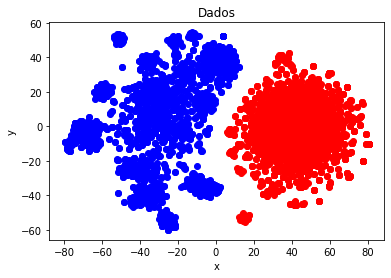

In [142]:
model = TSNE(n_components=2, random_state=0)
#model = PCA(n_components=50, svd_solver='full')
array_red = model.fit_transform(dfTfidfArray)

df_tsne = pd.DataFrame(array_red)

target = dfTfidfArray["Target"].array

df_tsne['Target'] = target
print(df_tsne)
df_tsne_c1 = df_tsne[df_tsne['Target'] == 0]

df_tsne_c2 = df_tsne[df_tsne['Target'] == 1]

plt.scatter(df_tsne_c1[0].array,df_tsne_c1[1].array,marker='o',color='blue')

plt.scatter(df_tsne_c2[0].array,df_tsne_c2[1].array,marker='o',color='red')

plt.title('Dados')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [143]:
df_features = dfTfidfArray.drop(columns=['Target'])
df_tsneTarget = df_tsne["Target"].array
df_tsneFeatures = df_tsne.drop(columns=['Target'])


df_features

,7gsolb,ability,able,absolutely,abuse,ac,accept,acceptance,accepted,access,...,yahoo,yeah,year,yes,yesterday,york,young,zawodny,zero,zone
ham0,0.000000,0.000000,0.053845,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham1,0.152286,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.503797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham2,0.073349,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.242655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ham4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spam1995,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam1996,0.000000,0.093633,0.000000,0.0,0.0,0.0,0.0,0.057789,0.0,0.0,...,0.041750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam1997,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spam1998,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
def getModel():
    return LogisticRegression()
#     return DecisionTreeClassifier()
#     return RandomForestClassifier()

In [145]:
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features.values,target,test_size=0.2)
modelo = getModel().fit(X_treino,y_treino)
score = modelo.score(X_teste,y_teste)
#score = modelo.score(["alo"],[1])
score

0.969264544456641

In [146]:
scores = cross_val_score(getModel(),df_features.values,target,cv=10)

scores.mean()

0.9657205513784461

In [147]:
predicoes = cross_val_predict(getModel(), df_features.values, target, cv=10)

cm = confusion_matrix(target,predicoes,labels=[0, 1])

cm_df = pd.DataFrame(cm, columns=[0, 1])

cm_df

,0,1
0,2450,101
1,55,1945


In [148]:
teste = pd.read_csv("spam_ham_dataset.csv").sample(frac=1)
teste2 =pd.read_csv("emails.csv").sample(frac=1)
targetTest2 = teste2["spam"]
teste = teste.drop(columns=["Unnamed: 0","label_num"])
teste = teste.replace({"ham":0,"spam":1})
targetTest = teste["label"]
teste2

,text,spam
601,Subject: save your money buy getting this thin...,1
3166,"Subject: akamai kevin , i have followed up o...",0
2130,Subject: summer position - - - - - - - - - - ...,0
3582,Subject: resid fx option - - - - - - - - - - ...,0
5354,"Subject: patricia tlapek brad , as per our p...",0
...,...,...
1401,"Subject: re : software license oh , ok , i di...",0
534,Subject: today ' s special : amazing penetrati...,1
4412,Subject: look forward to hearning from you . ...,0
3526,"Subject: re : eprm 2001 houston layla , a fe...",0


In [149]:
emailsTest = []

for email in teste2["text"].array:
    emailsTest.append(wordsPreProcessing(email))

emailsTest

['save money buy getting thing tried cialls imagine like real man bed thing great errrectlon provided exactly want cialls iot advantage viagra effect last hour ready start minute mix alcohol ship country riqht ',
 'akamai kevin followed request identify potential hire akamai person familiar technology start discussion target day let know unit eb potential hiring agent research inside eb sponsor position discus responsibility job description vince ',
 'summer position forwarded stinson gibner hou ect pm amy ruth ward pm celeste robert hou ect ect cc stinson gibner hou ect ect summer position dear celeste stinson writing refuse enron offer summer position conversation advisor stanford decided remain stanford work dissertation thank taking time enron sincerely amy ward ',
 'resid fx option forwarded zimin lu hou ect zimin lu stinson gibner hou ect ect paulo issler hou ect ect cc resid fx option created directory residfx monte carlo model c project calling spreadsheet valuation zimin ',
 '

In [150]:
tfidfVectorizerTest = TfidfVectorizer(analyzer="word",min_df=0.005,max_features=2100)
#tfidfVectorizer = TfidfVectorizer(analyzer="word")

tfidfTransformTest = tfidfVectorizerTest.fit_transform(emailsTest)

print(tfidfTransformTest)

  (0, 421)	0.20016234607642847
  (0, 1719)	0.2632804273494055
  (0, 1202)	0.19273404253246154
  (0, 1794)	0.16607875453108017
  (0, 1538)	0.19254378483796233
  (0, 860)	0.18115482050168347
  (0, 563)	0.21356465195226085
  (0, 2007)	0.22620008716382992
  (0, 36)	0.22243153212523772
  (0, 2034)	0.1348874784941063
  (0, 631)	0.2430617599631684
  (0, 1498)	0.19713048140801806
  (0, 792)	0.15156010191745678
  (0, 1135)	0.22465568803670552
  (0, 1539)	0.1779981538296255
  (0, 1073)	0.10731156333095561
  (0, 884)	0.266915835513182
  (0, 1950)	0.23723001977293032
  (0, 1906)	0.33587735038278316
  (0, 769)	0.18205441543741474
  (0, 232)	0.1906829851695302
  (0, 1216)	0.1733813383683202
  (0, 1652)	0.19254378483796233
  (1, 2012)	0.07033454536928352
  (1, 486)	0.20698632603266448
  :	:
  (5727, 481)	0.05527310737390377
  (5727, 117)	0.05792658508112276
  (5727, 125)	0.06961219542875302
  (5727, 1547)	0.06786076782295501
  (5727, 1441)	0.21344540516636604
  (5727, 1246)	0.037356294840635296
  (57

In [151]:
dfTfidfArrayTest = pd.DataFrame(data=tfidfTransformTest.toarray(), columns=tfidfVectorizerTest.get_feature_names_out())
dfTfidfArrayTest.insert(len(dfTfidfArrayTest.columns), "Target", targetTest2.array, True)
dfTfidfArrayTest

,aa,ability,able,absolutely,abstract,academic,accept,acceptable,acceptance,accepted,...,yahoo,yaman,year,yes,yesterday,york,young,ze,zimin,Target
0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.000000,1
1,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0
2,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0
3,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.451614,0
4,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.10877,0.0,0.00000,0.0,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.04867,0.0,0.000000,0.0,0.000000,0
5724,0.00000,0.0,0.0,0.323671,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.0,0.165501,0.0,0.000000,1
5725,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0
5726,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0


C:\Users\Renato Vidal\.conda\envs\ox\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Renato Vidal\.conda\envs\ox\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


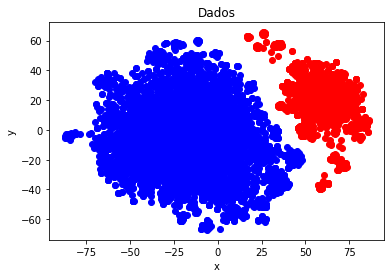

In [152]:


modelTest = TSNE(n_components=2, random_state=0)
#modelTest = PCA(n_components=50)
array_redTest = modelTest.fit_transform(dfTfidfArrayTest)

df_tsneTest = pd.DataFrame(array_redTest)
df_tsneTest['Target'] = targetTest2.array

df_tsne_c1Test = df_tsneTest[df_tsneTest['Target'] == 0]

df_tsne_c2Test  = df_tsneTest[df_tsneTest['Target'] == 1]

plt.scatter(df_tsne_c1Test[0].array,df_tsne_c1Test[1].array,marker='o',color='blue')

plt.scatter(df_tsne_c2Test[0].array,df_tsne_c2Test[1].array,marker='o',color='red')

plt.title('Dados')
plt.xlabel('x')
plt.ylabel('y')

plt.show()


In [153]:
df_tsneTargetTest = df_tsneTest["Target"].array
df_tsneFeaturesTest = df_tsneTest.drop(columns=['Target'])
dfTfidfArrayFeatures = dfTfidfArray.drop(columns=['Target'])
dfTfidfArrayTarget = dfTfidfArray["Target"].array

In [154]:
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features.values,target,test_size=0.01)
X_treinoTest, X_testeTest, y_treinoTest, y_testeTest = train_test_split(dfTfidfArrayFeatures.values,dfTfidfArrayTarget,test_size=0.01)
modelo = getModel().fit(X_treino,y_treino)
modelo2 = getModel().fit(X_treinoTest,y_treinoTest)
score = modelo.score(X_treinoTest,y_treinoTest)
score2 = modelo2.score(X_testeTest,y_testeTest)

print(score)
print(score2)

0.9875693673695893
0.9347826086956522


In [ ]:
predicoesTest = cross_val_predict(modelo, df_tsneFeaturesTest.values, df_tsneTargetTest, cv=10)

cmTest = confusion_matrix(df_tsneTargetTest,predicoesTest,labels=[0, 1])

cm_dfTest = pd.DataFrame(cmTest, columns=[0, 1])

cm_dfTest